In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
from callback import data_processing

import itertools

# 正規化
from sklearn.preprocessing import MinMaxScaler
import math

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Processing

In [2]:
def mk_dataframe(path):
    df = pd.read_table(path, sep=" ", header=None)
    df = df.drop(columns=0, axis=1)
    df = df.drop(columns=df.shape[1], axis=1)
    return df

df = mk_dataframe("230728/pos-3.dat")

In [3]:
df_ = df.values

In [4]:
df_.shape

(36000, 60)

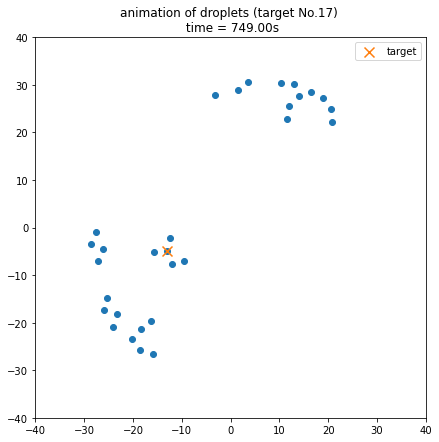

In [72]:
fig = plt.figure(figsize=(7,7))

start_time = 0
target = 17
def plot(time):
    plt.cla()                   # 前のグラフを削除
    
    time *= 10
    plt.scatter(df_[time+start_time,::2], df_[time+start_time,1::2])
    plt.scatter(df_[time+start_time,target*2], df_[time+start_time, target*2 + 1], marker="x", s=100, label = "target")
    plt.title("animation of droplets (target No.{}) \n time = {:.2f}s".format(target, (time+start_time) * 0.1))
    plt.legend()
    plt.xlim(-40,40)
    plt.ylim(-40,40)

    return fig

ani = animation.FuncAnimation(fig, plot, frames=750, interval=100)

from IPython.display import HTML
HTML(ani.to_html5_video())

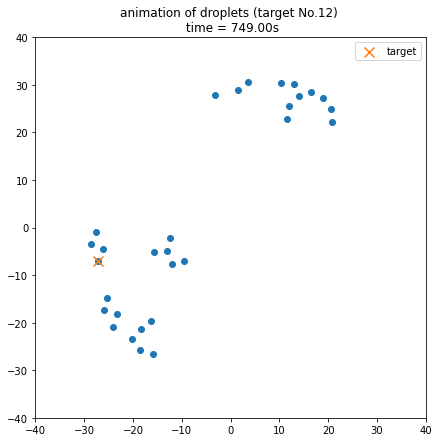

In [32]:

start_time = 0
target = 12
fig = plt.figure(figsize=(7,7))

def plot(time):
    plt.cla()                   # 前のグラフを削除
    
    time *= 10
    plt.scatter(df_[time+start_time,::2], df_[time+start_time,1::2])
    plt.scatter(df_[time+start_time,target*2], df_[time+start_time, target*2 + 1], marker="x", s=100, label = "target")
    plt.title("animation of droplets (target No.{}) \n time = {:.2f}s".format(target, (time+start_time) * 0.1))
    plt.legend()
    plt.xlim(-40,40)
    plt.ylim(-40,40)

    return fig

ani = animation.FuncAnimation(fig, plot, frames=750, interval=100)

from IPython.display import HTML
HTML(ani.to_html5_video())

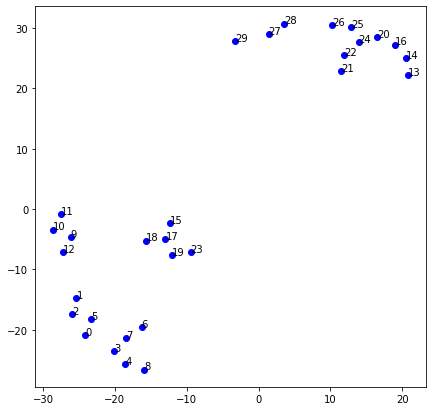

In [70]:
plt.figure(figsize=(7,7))
for i in range(30):
    plt.scatter(df_[7490,i*2], df_[7490,i*2+1], color="b")
    plt.text(df_[7490,i*2], df_[7490,i*2+1], i)

In [33]:
df_to_use = df_[:7500]

In [34]:
n_nearest_neighbors = 4
data_for12 = data_processing.DataProcessing(df_to_use, n_nearest_neighbors=4, target_no=12, split_angle=45)
data_for17 = data_processing.DataProcessing(df_to_use, n_nearest_neighbors=4, target_no=17, split_angle=45)

In [35]:
labels_for12, data_d_and_angle_for12 = data_for12()
labels_for17, data_d_and_angle_for17 = data_for17()

In [36]:
labels_for12

array([6., 2., 5., ..., 6., 3., 7.])

In [37]:
data_d_and_angle_for12[0]

array([ 0.00038359, -0.02752256, -0.0045956 , -0.00277418,  0.01482092,
       -0.03292513,  0.03122154, -0.00748073])

In [10]:
t_list = []
for i in range(4):
    distance = math.sqrt(data_d_and_angle[0,i*4] ** 2 + data_d_and_angle[0,i*4+1] ** 2)
    print(distance )
    t_list.append(distance)

2.782615302996265
2.787316233876203
2.827208153924079
4.716698934905836


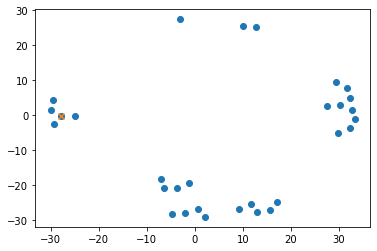

In [14]:
plt.scatter(df_to_use[0,::2], df_to_use[0,1::2])
plt.scatter(df_to_use[0,17*2], df_to_use[0,17*2+1], marker="x")

### Labels and their size

In [39]:
np.unique(labels_for12, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
 array([ 816,  801,  928, 1258, 1029,  727,  752,  894,  293]))

In [42]:
np.unique(labels_for17, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
 array([1041,  942,  800,  848,  870,  936,  933, 1026,  102]))

### delete label meaning stop

In [61]:
def delete_label_stop(data, labels):
    delete_index = np.where(labels == 8)[0]
    data = np.delete(data, [i for i in delete_index], axis=0)
    labels = np.delete(labels, [i for i in delete_index], axis=0)
    return data, labels

In [64]:
data_d_and_angle_for12, labels_for12 = delete_label_stop(data_d_and_angle_for12, labels_for12)
data_d_and_angle_for17, labels_for17 = delete_label_stop(data_d_and_angle_for17, labels_for17)

In [65]:
np.unique(labels_for12, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7.]),
 array([ 816,  801,  928, 1258, 1029,  727,  752,  894]))

In [68]:
# Concatenate the arrays along the rows (axis=0)
data_d_and_angle = np.concatenate((data_d_and_angle_for12, data_d_and_angle_for17), axis=0)
labels = np.concatenate((labels_for12, labels_for17), axis=0)

In [69]:
np.unique(labels, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7.]),
 array([1857, 1743, 1728, 2106, 1899, 1663, 1685, 1920]))

### Normalize data

In [25]:
from sklearn.preprocessing import MinMaxScaler
"""# 距離を正規化
data_d_and_angle[:, ::4] /= 6
# 角度による標準化
data_d_and_angle[:, 1::4] /= 360"""


scaler = MinMaxScaler()
data_d_and_angle = scaler.fit_transform(data_d_and_angle)

In [26]:
data_d_and_angle[0]

array([0.00328441, 0.50894956, 0.54270322, 0.42829335, 0.7686971 ,
       0.92258032, 0.39838201, 0.46856953, 0.89698963, 0.19585121,
       0.42562715, 0.43984646, 0.68742358, 0.03784922, 0.39550427,
       0.33568755])

In [109]:
np.max(data_d_and_angle[:,::4])

0.9369265080286769

### Create Dataset and DataLoader

In [11]:
X = torch.tensor(data_d_and_angle, dtype=torch.float32)
target = torch.tensor(labels, dtype=torch.int64) 

# 目的変数と入力変数をまとめてdatasetに変換
dataset = torch.utils.data.TensorDataset(X,target)

# 各データセットのサンプル数を決定
# train : val : test = 80% : 10% : 10%
n_train = int(len(dataset) * 0.8)
n_val = int((len(dataset) - n_train) * 0.5)
n_test = len(dataset) - n_train - n_val

# データセットの分割
torch.manual_seed(0) #乱数を与えて固定
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val,n_test])

In [12]:
#バッチサイズ
batch_size = 100

# 乱数のシードを固定して再現性を確保
torch.manual_seed(0)

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

# 辞書型変数にまとめる(trainとvalをまとめて出す)
dataloaders_dict = {"train": train_loader, "val": val_loader}

## Model Define

In [17]:
class Net(nn.Module):

    # 使用するオブジェクトを定義
    def __init__(self, n_nearest_neighbors):
        super(Net, self).__init__()
        self.input_dim = n_nearest_neighbors * 2
        
        self.layers1 = nn.Sequential(
            nn.Linear(self.input_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 70),
            nn.ReLU()
        )
        self.layers2 = nn.Sequential(
            nn.Dropout(p=0.3, inplace=False),
            nn.BatchNorm1d(70),
            nn.Linear(70, 9)
        )

    # 順伝播
    def forward(self, x):
        
        x = self.layers1(x)
        out = self.layers2(x)
        return out    

In [18]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  # Clear the gradients
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss /= len(train_loader)
    accuracy = 100.0 * correct / total
    
    return train_loss, accuracy


def evaluate(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    test_loss /= len(test_loader)
    accuracy = 100.0 * correct / total
    
    return test_loss, accuracy


## Train

In [22]:
# インスタンス化
net = Net(n_nearest_neighbors=4)

# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# 最適化手法の選択
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

epochs = 2000

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
loss = {
    "train": [],
    "val": []
}

for i in range(epochs):
    train_loss, train_acc = train(net, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(net, val_loader, criterion, device)
    
    loss["train"].append(train_loss)
    loss["val"].append(val_loss)
    
    if i == 0 or (i+1) % 50 == 0:
        print("epoch: {:>3}, train_loss: {:.4f}, train_acc: {:.2f}%, val_loss: {:.4f}, val_acc: {:.2f}%".format(
            i+1, train_loss, train_acc, val_loss, val_acc))

epoch:   1, train_loss: 2.2643, train_acc: 11.65%, val_loss: 2.1875, val_acc: 12.93%
epoch:  50, train_loss: 2.1671, train_acc: 14.55%, val_loss: 2.1404, val_acc: 16.00%
epoch: 100, train_loss: 2.1138, train_acc: 17.34%, val_loss: 2.1030, val_acc: 18.67%
epoch: 150, train_loss: 2.0774, train_acc: 19.26%, val_loss: 2.0695, val_acc: 19.73%
epoch: 200, train_loss: 2.0545, train_acc: 20.54%, val_loss: 2.0683, val_acc: 19.73%
epoch: 250, train_loss: 2.0466, train_acc: 19.86%, val_loss: 2.0493, val_acc: 22.00%
epoch: 300, train_loss: 2.0370, train_acc: 20.84%, val_loss: 2.0536, val_acc: 20.13%
epoch: 350, train_loss: 2.0381, train_acc: 20.71%, val_loss: 2.0535, val_acc: 21.07%
epoch: 400, train_loss: 2.0337, train_acc: 21.27%, val_loss: 2.0431, val_acc: 22.53%
epoch: 450, train_loss: 2.0311, train_acc: 20.99%, val_loss: 2.0468, val_acc: 22.40%
epoch: 500, train_loss: 2.0248, train_acc: 20.81%, val_loss: 2.0482, val_acc: 22.27%
epoch: 550, train_loss: 2.0279, train_acc: 20.76%, val_loss: 2.04

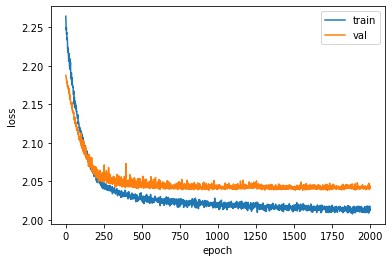

In [24]:
plt.plot(range(epochs), loss["train"], label="train")
plt.plot(range(epochs), loss["val"], label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

In [49]:
for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()  # Clear the gradients
    
    outputs = net(inputs)  # Forward pass
    loss = criterion(outputs, labels)  # Calculate the loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update the weights
    
    train_loss += loss.item()
    print(outputs)
    _, predicted = outputs.max(1)
    labels.size(0)
    predicted.eq(labels).sum().item()
    
    break

tensor([[ 1.6839e+00,  1.1495e+00,  1.0687e+00,  1.9265e-01, -9.8264e-01,
         -3.8562e-01, -4.9503e-01,  1.5177e-01, -1.8217e+00],
        [ 1.4909e+00,  1.7740e+00, -2.8575e-01,  7.6250e-01, -1.4824e+00,
         -1.3986e+00, -5.0355e-01, -4.6130e-01, -2.2553e+00],
        [ 5.5777e-01, -5.9587e-01, -5.6921e-01, -1.2429e+00, -5.8874e-01,
         -2.2756e-01,  1.2745e+00,  1.9404e+00, -1.3275e+00],
        [ 1.9700e+00,  1.8373e+00,  7.9763e-01, -1.3523e+00, -1.8073e+00,
         -2.1422e+00, -7.1922e-01,  7.4617e-01, -1.1857e+00],
        [-1.0974e+00,  2.5088e-01,  3.4557e-01,  1.0354e+00,  1.5134e+00,
          3.7417e-01, -1.1297e+00, -7.9042e-01, -1.0154e+00],
        [ 1.0104e+00,  2.2513e-01,  1.9707e-01, -3.4009e-01, -5.1572e-01,
         -4.5109e-02,  5.4473e-01,  9.9841e-01, -1.0366e+00],
        [ 1.4171e+00,  3.5104e-01,  1.2250e-01, -7.0222e-01, -8.0491e-01,
         -4.4486e-01,  7.1164e-01,  1.2962e+00, -1.1442e+00],
        [-2.0210e+00, -7.2842e-01,  4.6796e-01, 